Because things werent really working, the idea here is to create a sine wave, map it to the lin, log and cept domains, and see if i can do the same with a hmm trained in the cept domain, (i.e train it in the cept domain, map it back) it should be the same

In [1]:
import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/classifiers/fhmm/pmc_development', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
from importlib import reload
import audio_datastore.audio_datastore as myads
reload(myads)
import numpy as np
import matplotlib.pyplot as plt
from python_speech_features import mfcc
from importlib import reload
import hmmlearn.hmm as hmm
import utils
reload(utils)
from spafe.utils import vis
from matplotlib.pyplot import figure
figure(figsize=(4, 4), dpi=60)
from scipy.fftpack import dct, idct

Using cache found in /Users/david/.cache/torch/hub/snakers4_silero-vad_master
Using cache found in /Users/david/.cache/torch/hub/snakers4_silero-vad_master


<Figure size 240x240 with 0 Axes>

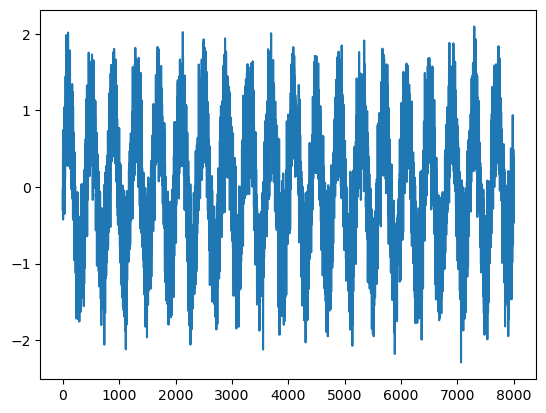

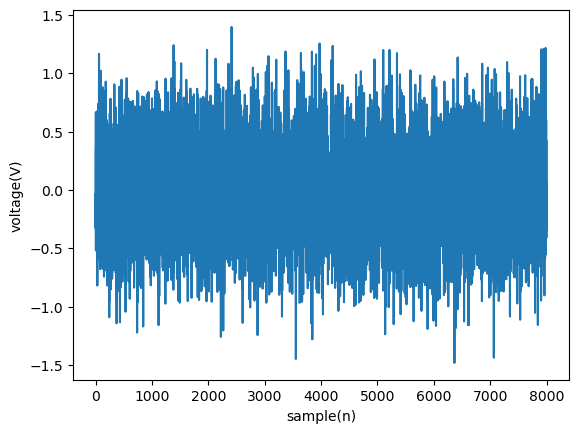

In [35]:
fs = 8000
f1 = 20 # hz
f2 = 2000
sample = 8000
x = np.arange(sample)
noise = np.random.normal(0, np.sqrt(0.153162), sample)
s1 = np.sin(2 * np.pi * f1 * x / fs) + noise
# s2 = np.sin(np.pi * f2 * x / Fs)
# s1_og = s1
# s2_og = s2
# plt.plot(x, s2)
plt.plot(x, s1)
plt.show()
plt.plot(x, noise)
# plt.plot(x, noise)
plt.xlabel('sample(n)')
plt.ylabel('voltage(V)')
plt.show()

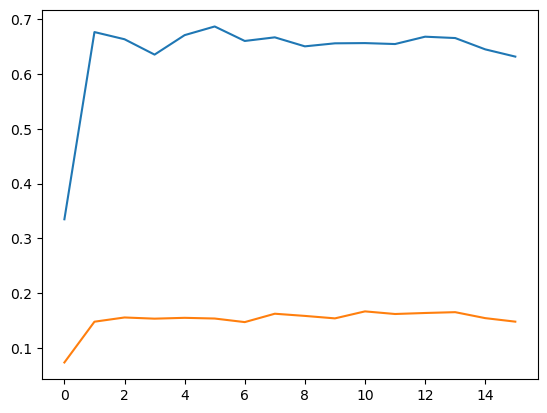

In [36]:
import utils
s1_average_power = utils.get_average_power(s1, use_buffer=True, show_graph=True)
noise_average_power = utils.get_average_power(noise, use_buffer=True, show_graph=True)

In [48]:
snr_db = 10 * np.log10(s1_average_power / noise_average_power)
snr = s1_average_power / noise_average_power
# snr_db
##
noise_average_power = s1_average_power / np.power(10, 10 / 10)
noise_average_power

0.06391582065512777

In [38]:
from spafe.features import mfcc

cept_features = mfcc.mfcc(s1, fs, num_ceps=24)
cept_hmm = hmm.GaussianHMM(1)
cept_hmm.fit(cept_features)

lin_features, _ = mfcc.mel_spectrogram(s1, fs)
lin_hmm = hmm.GaussianHMM(1)
lin_hmm.fit(lin_features)

log_features = np.log(lin_features)
log_hmm = hmm.GaussianHMM(1)
log_hmm.fit(log_features)

# vis.show_features(cept_features, 'title', 'x', 'y')

GaussianHMM()

In [39]:
import classifiers.fhmm.helper_functions as hf
reload(hf)

def plot_params(params: hf.StatParams, gauss_hmm: hmm.GaussianHMM):
    x_axis = np.arange(len(params.mu.flatten()))
    params_var = np.diag(params.cov[0, :, :])
    hmm_var = np.diag(gauss_hmm.covars_[0, :, :])
    plt.stem(x_axis, params.mu.flatten() + params_var, linefmt='g')
    plt.stem(x_axis, params.mu.flatten() - params_var, linefmt='g')
    plt.plot(x_axis, params.mu.flatten(), c='g')
    plt.stem(x_axis, gauss_hmm.means_.flatten() + hmm_var, linefmt='b')
    plt.stem(x_axis, gauss_hmm.means_.flatten() - hmm_var, linefmt='b')
    plt.plot(x_axis, gauss_hmm.means_.flatten(), c='b')


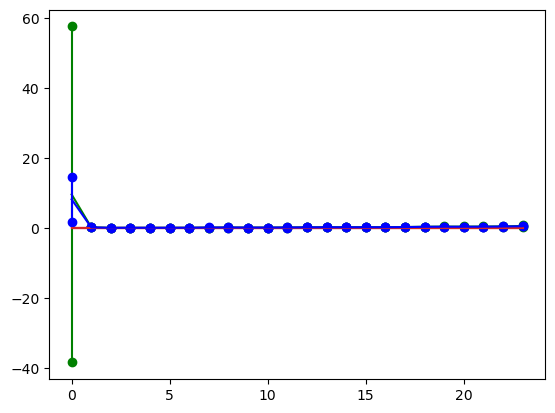

In [44]:
# lin_params = hf.StatParams(lin_hmm.means_, lin_hmm.covars_)
pm = hf.ParamMapper(lin_hmm.means_)
# plot_params(lin_params, lin_hmm)
# lin to log
# log_params = pm.map_linear_to_log(lin_params)
# plot_params(log_params, log_hmm)
# # log to cept
# cept_params = pm.map_log_to_cepstral(log_params)
# plot_params(cept_params, cept_hmm)
# # cept to lin
cept_params = hf.StatParams(cept_hmm.means_, cept_hmm.covars_)
log_params = pm.map_cepstral_to_log(cept_params)
# plot_params(log_params, log_hmm)
# # first one still bwoken ?
lin_params = pm.map_log_to_linear(log_params)
plot_params(lin_params, lin_hmm)

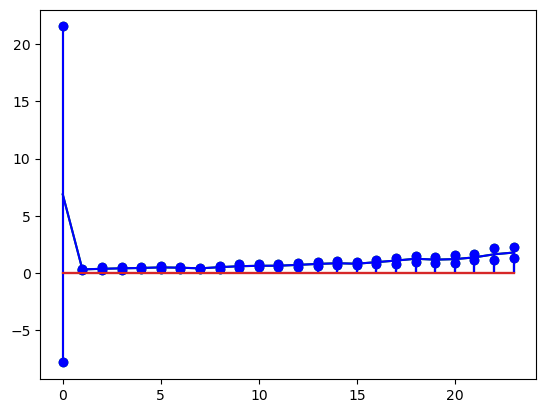

In [60]:
lin_params = hf.StatParams(lin_hmm.means_, lin_hmm.covars_)
cept_params = pm.map_linear_to_cepstral(lin_params)
lin_params = pm.map_cepstral_to_linear(cept_params)
plot_params(lin_params, lin_hmm)